<a href="https://colab.research.google.com/github/locoblueog/locoblueog/blob/main/Week2/TMDL_2024_25_Assignment_2_PS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Turing Machine and Deep Learning

## Assignment 2: Supervised Classification Problems

This notebook is meant for you to review and reflect on the content of Lecture 2, which was mainly about supervised learning problems in the general context of classification. We will reflect mainly on model and hyperparameter selection over the models we have discussed during the lecture: logistic regression, decision trees, random forests and support vector machines. This notebook should not be too much quantitative work (lines of code) but keep in mind that running this notebook may take a longer time than you may be used to for python programs (*training good models take time!*)

### Handing in your Assignment

Git is an invaluable resource to researchers and developers, and thus for this course, all course material will be (additionally) shared on GitHub. Though there is a tiny bit of a learning curve, this is worth the effort. To hand in your assignment (applicable to all weeks):

1. Create a folder called "Week 2" and copy this notebook and any other files or data that may be needed.
2. Finish the notebook and commit and push regularly. Your final commit before the deadline will be graded.


# Question 1 -- Classification Metrics

To contextualise, we learnt of 4 metrics in class: accuracy, precision, recall and F1 score. Answer the following text questions in the following markdown cell.
1. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would be preferable.
2. For accuracy, precision and recall, mention one specific example *each* (i.e. a well-defined problem where ML can be used) where they would fail.
3. In which situations would the F1 score be helpful? Give one concrete example.

1. Best use cases for each metric:
Accuracy: Email filtering - when most emails are legitimate and misclassification costs are similar.
Precision: Dating app recommendations - users prefer fewer but highly compatible matches rather than many mediocre ones.
Recall: Cancer screening - missing a cancer diagnosis could be fatal, while false alarms just lead to more tests.
2. When each metric fails:
Accuracy: Credit card fraud detection - if only 0.1% of transactions are fraudulent, simply classifying everything as "not fraud" gives 99.9% accuracy but catches zero fraud.
Precision: Earthquake early warning system - focusing only on precision might delay alerts until absolutely certain, potentially costing lives.
Recall: Airport security - maximizing recall alone would flag nearly every passenger as suspicious, creating massive delays.
3. F1 score usefulness:
Example: Job application screening - companies need to balance finding qualified candidates (recall) without wasting interview slots on poor fits (precision). F1 score helps HR teams identify enough good candidates without drowning in unqualified applications.

## Question 2 -- CIFAR 10

As we've discussed last week, one of the prime issues with ML is figuring out what model you are going to use and when. In this case, we're going to use the [CIFAR-10](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) dataset from TensorFlow, another benchmarking dataset. This is a considerably larger dataset, and contains coloured images. For the sake of computation time, we are just going to use the first 1000 training images but the full test set (though in a proper ML setting we would prefer to use all training data). The images are 32x32 coloured pixes. There are 10 labels which are integers by default. The dictionary `class_labels` translate them to their text label equivalents (referenced from [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data)).

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


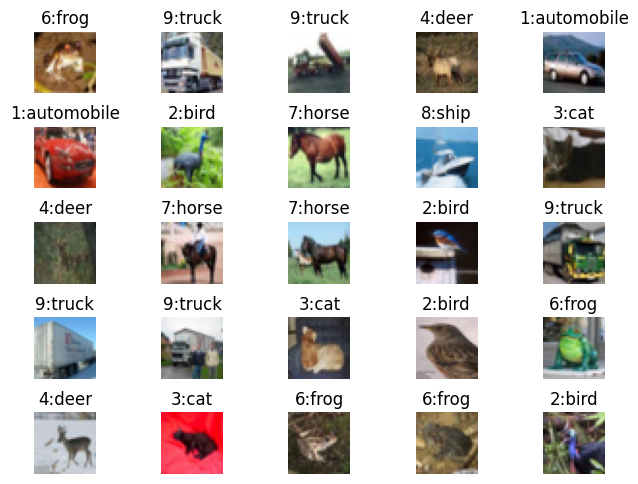

In [ ]:
# don't need to edit anything here,
# just run this cell

# get dataset
from tensorflow.keras.datasets import cifar10
# get common libraries
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm # this is a new one: makes loading bars

def get_data_subset(n_train, n_test):
    (train_X, train_y), (test_X, test_y) = cifar10.load_data()
    train_X, train_y, test_X, test_y = train_X[:n_train], train_y[:n_train], test_X[:n_test], test_y[:n_test]
    train_y, test_y = train_y.squeeze(), test_y.squeeze()
    return train_X, train_y, test_X, test_y

n_train, n_test = 1000, 1000

train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

fig, axs = plt.subplots(5,5)
axs = axs.flatten()
fig.tight_layout(pad=0.3)

class_labels = {0:"airplane",
                1:"automobile",
                2:"bird",
                3:"cat",
                4:"deer",
                5:"dog",
                6:"frog",
                7:"horse",
                8:"ship",
                9:"truck"}

for i, ax in enumerate(axs):
    ax.imshow(train_X[i])
    ax.set_title(f"{train_y[i]}:{class_labels[train_y[i]]}")
    ax.axis("off")

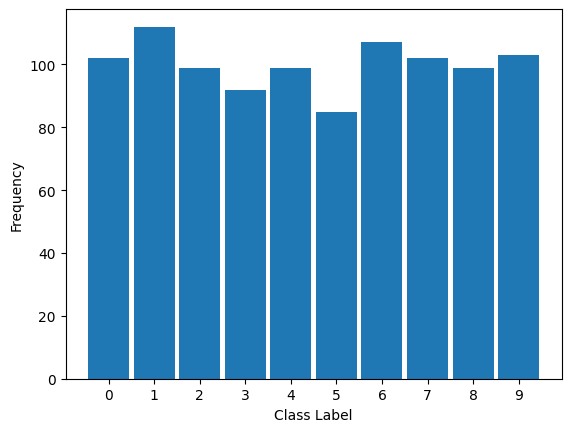

In [ ]:
# making sure the quantity of examples for each label are about the same
plt.hist(train_y, bins=10, rwidth=0.9)
plt.xticks(0.9*np.arange(10)+0.45, range(10))
plt.ylabel("Frequency")
plt.xlabel("Class Label")
plt.show()

## Question 2.1 -- Preprocessing

The first thing we should do is preprocess the images so that they are ready to be input into our models. First, print out the shape of the dataset's inputs (`train_X`).

In [ ]:
print("Shape of train_X:", train_X.shape)

Shape of train_X: (1000, 32, 32, 3)


**Q 2.1.1** What does each value in the tuple that was printed out
mean?

1000 → The number of training images

32 → The height of each image in pixels

32 → The width of each image in pixels

3 → The number of color channels (RGB: Red, Green, Blue)

**Q 2.1.2** Next, flatten the pixel values to a single vector. What is the length of this vector? Print out the shape of the flattened dataset's inputs once more.

In [ ]:
# Your answer here
def flatten_cifar10(samples):
    return samples.reshape(samples.shape[0], -1)  # Flatten each image into a 1D vector

train_X, test_X = flatten_cifar10(train_X), flatten_cifar10(test_X)

# Print the new shape
print("Shape of flattened train_X:", train_X.shape)
print("Shape of flattened test_X:", test_X.shape)


Shape of flattened train_X: (1000, 3072)
Shape of flattened test_X: (1000, 3072)


## Question 3 -- Model Selection using Grid Search

In the lecture, we have seen four different ML classification algorithms: logistic regression, decision trees, random forests and support vector machines. In this assignment, we will figure out which is best, and a basic method to figure out the best way to tune the parameters of each one. Remember, a hyperparameter is something that you choose by hand about the model or the way it trains.

### Question 3.1 -- Logistic regression

Use `sklearn` (as in the lecture notebook) to classify the CIFAR10 sub-dataset. There are not a lot of major hyperparameters to tune here, so this exercise should be straightforward. Create a LogisticRegression object, fit it on the training data, and compute the train and test accuracies.

*Expected runtime: ~1min*

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create the logistic regression object with a solver suited for multi-class classification
modelLR = LogisticRegression(max_iter=200, solver='saga', multi_class='multinomial', n_jobs=-1)

# Fit on training data
modelLR.fit(train_X, train_y)

# Compute accuracy
train_accuracy = modelLR.score(train_X, train_y)
test_accuracy = modelLR.score(test_X, test_y)

# Print results
print("Training score:", train_accuracy)
print("Testing score: ", test_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training score: 0.931
Testing score:  0.278


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Q 3.1.2** Does the model work well in your opinion? What about whether it is over/underfitting?

The training score is good (0.931), however the testing score is low (0.279). This indicates that the model is overfitting significantly, as it performs well on the training data but bad on new, unseen data, and thus generalisation.

The model is memorising more than learning.

### Question 3.2 -- Decision Trees

Decision trees have one main hyperparameter that you can tune -- this is the maximum depth of the tree being trained. Thus, we'll try and figure out what depth is the optimal for our purposes.

An important thing to note is that decision trees are randomized initially -- this means that two trees of the same depth may have wildly different performances, depending on how they were initialized.

**Q 3.2.1** Loop over max tree depths from $d=1$ to $d=15$ and store the mean and standard deviation of train and test scores for 10 randomly initialised trees.

*Expected runtime: <5 mins*

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score

train_acc_mean, train_acc_std = [], []  # Store training accuracies
test_acc_mean, test_acc_std = [], []    # Store testing accuracies

for d in tqdm(range(1, 16)):  # Loop over tree depths from 1 to 15
    train_perfs = []  # Store intermediate train scores
    test_perfs = []   # Store intermediate test scores

    for n in range(10):  # Loop over 10 random initializations
        modelDT = tree.DecisionTreeClassifier(max_depth=d, random_state=n)  # Initialize model
        modelDT.fit(train_X, train_y)  # Train model

        # Compute train & test accuracy
        train_perfs.append(modelDT.score(train_X, train_y))
        test_perfs.append(modelDT.score(test_X, test_y))

    # Append mean and std scores to appropriate lists
    train_acc_mean.append(np.mean(train_perfs))
    train_acc_std.append(np.std(train_perfs))
    test_acc_mean.append(np.mean(test_perfs))
    test_acc_std.append(np.std(test_perfs))

# Print results
for d in range(1, 16):
    print(f"Depth {d}: Train Acc = {train_acc_mean[d-1]:.3f} ± {train_acc_std[d-1]:.3f}, "
          f"Test Acc = {test_acc_mean[d-1]:.3f} ± {test_acc_std[d-1]:.3f}")



100%|██████████| 15/15 [06:24<00:00, 25.61s/it]

Depth 1: Train Acc = 0.174 ± 0.000, Test Acc = 0.172 ± 0.000
Depth 2: Train Acc = 0.224 ± 0.000, Test Acc = 0.198 ± 0.000
Depth 3: Train Acc = 0.275 ± 0.000, Test Acc = 0.224 ± 0.000
Depth 4: Train Acc = 0.325 ± 0.000, Test Acc = 0.221 ± 0.002
Depth 5: Train Acc = 0.400 ± 0.000, Test Acc = 0.213 ± 0.002
Depth 6: Train Acc = 0.467 ± 0.001, Test Acc = 0.217 ± 0.003
Depth 7: Train Acc = 0.549 ± 0.001, Test Acc = 0.192 ± 0.006
Depth 8: Train Acc = 0.649 ± 0.001, Test Acc = 0.212 ± 0.006
Depth 9: Train Acc = 0.723 ± 0.001, Test Acc = 0.204 ± 0.005
Depth 10: Train Acc = 0.793 ± 0.003, Test Acc = 0.208 ± 0.006
Depth 11: Train Acc = 0.857 ± 0.004, Test Acc = 0.209 ± 0.004
Depth 12: Train Acc = 0.912 ± 0.002, Test Acc = 0.215 ± 0.005
Depth 13: Train Acc = 0.952 ± 0.002, Test Acc = 0.205 ± 0.009
Depth 14: Train Acc = 0.974 ± 0.002, Test Acc = 0.215 ± 0.008
Depth 15: Train Acc = 0.986 ± 0.002, Test Acc = 0.211 ± 0.008


**Q 3.2.2** Plot the test and train means with errorbars equal to one standard deviation (look at [plt.errorbar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html) for reference). Don't forget to add labels.

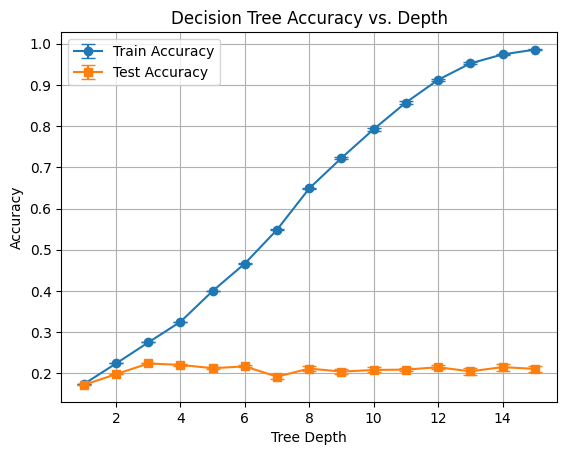

In [ ]:
# Plot train & test accuracy with error bars
plt.errorbar(range(1, 16), train_acc_mean, yerr=train_acc_std, label="Train Accuracy", fmt='-o', capsize=5)
plt.errorbar(range(1, 16), test_acc_mean, yerr=test_acc_std, label="Test Accuracy", fmt='-s', capsize=5)

# Labels and title
plt.title("Decision Tree Accuracy vs. Depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

# Show plot
plt.show()

**Q 3.2.3**

1. Is there a lot of variation of the performance of the trees (enough to question statistical significance)?
2. Which model (of the ones you tested) performed best on the training set? Which performed best on the test set?
3. At what depth do models start to overfit the training data?

Variation in performance:
There appears to be very little variation in performance for each tree depth as indicated by the small error bars on the data points. This suggests the results are statistically significant, and the performance patterns we observe are reliable rather than due to random chance.
Best performing models:

Best on training set: The decision tree with depth 15 (the deepest tree tested) performed best on the training set, reaching nearly 100% accuracy.
Best on test set: The performance on the test set is much more consistent across different depths. The highest test accuracy appears to be around depths 3/4, though the differences are minimal. After depth 3, the test accuracy hovers around 20-22% regardless of further increases in depth.

Overfitting:
Models start to overfit when the training accuracy continues to improve while the test accuracy plateaus or decreases. Based on the graph, overfitting begins around depth 3.

After this point:

-The training accuracy continues to climb steadily toward 100%

-The test accuracy remains flat at around 20-22%

-The gap between training and test accuracy grows dramatically with increasing depth

This is a classic example of overfitting, where the model becomes increasingly specialized to the training data's patterns and noise, while failing to generalize to new data.

Comparing the decision tree with the logical regression model, results are similar but not the same. With the first model, the train score was similar (from a depth of 12) and the test score was better (0.279 > ca. 0.22).

## Question 3.3 -- Random Forests
Just like in the decision trees, one hyperparameter you can choose is the depth of the tree. However, another important one is the number of decision trees. In this case, the performance is affected by the combination of these hyperparameters, and so we need to train and evaluate them at each combination.

**Q 3.3.1** Loop over $n_{trees}=10$ to $n_{trees}=100$ in increments of 10, and max tree depths from $d\in[1,3,5,7,9,11,13,15]$ and store the mean and standard deviation of train and test scores for 5 randomly initialised trees.

*Expected runtime: ~9 minutes*

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
import numpy as np
from tqdm import tqdm

# Initialize storage for means and stds
train_acc_mean, train_acc_std = np.zeros((10, 8)), np.zeros((10, 8))
test_acc_mean, test_acc_std = np.zeros((10, 8)), np.zeros((10, 8))

# Define hyperparameters
n_trees_list = list(range(10, 110, 10))  # [10, 20, ..., 100]
depths = [1, 3, 5, 7, 9, 11, 13, 15]

# Loop over number of trees and depths
for tree_idx, n_trees in tqdm(enumerate(n_trees_list), total=len(n_trees_list)):
    for d_idx, d in enumerate(depths):
        train_perfs = []
        test_perfs = []

        for _ in range(5):  # Run 5 times for randomness control
            model = RFC(n_estimators=n_trees, max_depth=d, random_state=None, n_jobs=-1)
            model.fit(train_X, train_y)  # Train the model

            # Store accuracy scores
            train_perfs.append(model.score(train_X, train_y))
            test_perfs.append(model.score(test_X, test_y))

        # Compute mean and std deviations
        train_acc_mean[tree_idx][d_idx] = np.mean(train_perfs)
        train_acc_std[tree_idx][d_idx] = np.std(train_perfs)
        test_acc_mean[tree_idx][d_idx] = np.mean(test_perfs)
        test_acc_std[tree_idx][d_idx] = np.std(test_perfs)


100%|██████████| 10/10 [10:01<00:00, 60.15s/it]


Looping over several variables and testing each combination is called a **grid search**. Since we have two hyperparameters, we cannot plot a 1D line to see which is best, as we did for normal DTs. One way to visualize this instead is a heatmap. For this, we can `seaborn`'s [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) function.  

**Q 3.3.2** Plot two heatmaps: one for the train accuracies and one for the test ones.

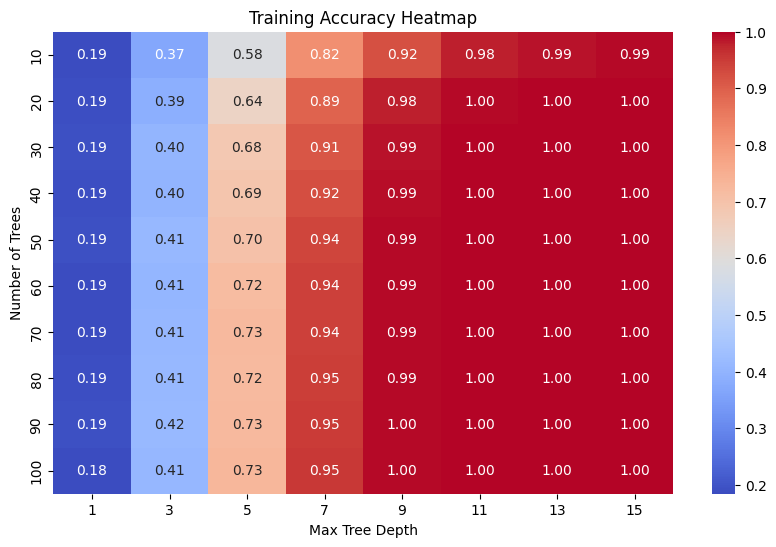

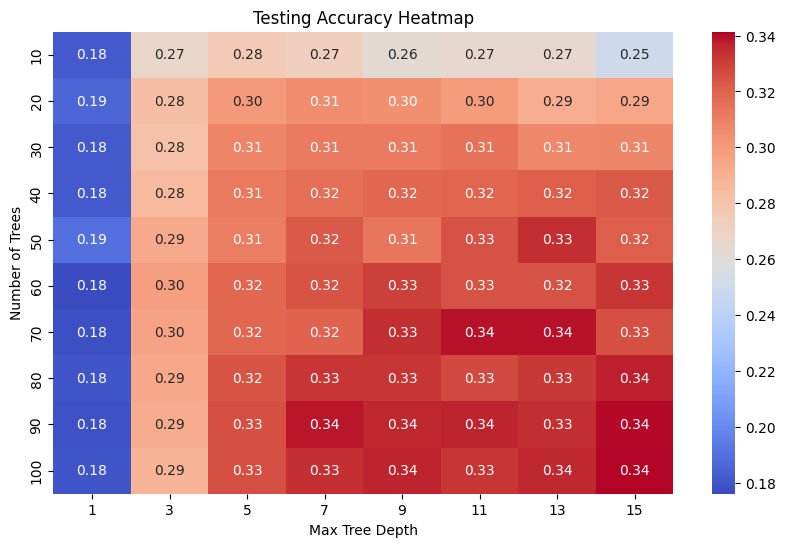

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define tick labels for heatmap
xticklabels = [1, 3, 5, 7, 9, 11, 13, 15]  # Depth values
yticklabels = list(range(10, 110, 10))  # Number of trees

# Figure 1 - Train Accuracy Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train_acc_mean, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel("Max Tree Depth")
plt.ylabel("Number of Trees")
plt.title("Training Accuracy Heatmap")
plt.show()

# Figure 2 - Test Accuracy Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(test_acc_mean, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel("Max Tree Depth")
plt.ylabel("Number of Trees")
plt.title("Testing Accuracy Heatmap")
plt.show()

**Q 3.3.2**
1. What trends with respect to each hyperparameter do the heatmaps show you?
2. What model performs best on the train set? What model performs best on the test set?
3. What model would you choose to deploy and why?

1. Trends for each hyperparameter:
Max Tree Depth:

Training accuracy increases dramatically with tree depth, rising from ~0.19 at depth 1 to near-perfect 1.00 at depths 9+
Testing accuracy improves more modestly with tree depth, from ~0.18 at depth 1 to ~0.32-0.34 at depths 5+
Test accuracy plateaus after depth 5, with minimal gains beyond this point

Number of Trees:

Training accuracy shows minimal variation with increasing tree numbers for any given depth
Testing accuracy gradually improves with more trees, particularly at higher depths
The improvement from 10 trees to 100 trees is modest but noticeable (~0.25 to ~0.34 at depth 15)

2. Best performing models:
Best on train set:

Models with depth 9+ and 20+ trees achieve perfect or near-perfect (1.00) training accuracy
The absolute best are depths 11-15 with 20+ trees (all showing 1.00)

Best on test set:

The highest test accuracy is ~0.34, achieved by several configurations:

60-80 trees at depth 13
90-100 trees at depths 9, 11, and 15



3. Model to deploy:
I would choose a random forest with 50 trees and max depth 7. This model achieves:

Good test accuracy (~0.33) that's very close to the best observed (0.34)
Much lower complexity than deeper models
Better computational efficiency than models with more trees
Lower risk of overfitting than models with greater depth
Good balance of model simplicity and performance

This choice represents a practical trade-off between performance and efficiency. The minimal gains in test accuracy beyond this configuration (only ~0.01) don't justify the additional computational cost and increased risk of overfitting from more complex models.

## Question 3.4 -- Support Vector Machines

`sklearn`'s SVM classifier implementation (called "SVC", we already met them in the lecture) contains quite a number of hyperparameters you can tune. The ones we are looking at today are the kernel, the parameter `C` (which is some penalty term for incorrectly classifying a data point, applicable to the RBF kernel), `gamma`, which is a measure of how important closer points to the decision boundary are with respect to the decision boundary (applicable to the RBF kernel), and `degree`, which is the degree of the polynomial function (applicable to the poly kernel). Let $C\in\{0.1, 1, 10, 100\}$ and $gamma\in\{10^x|-2\leq x\leq 2, x\in\mathbb{Z}\}$. Let us use $degree\in\{2,3,4\}$.

A note about the kernel: In short, this is a function that determines what the shape of the decision boundary are. The choices that we can check out here (there are more) are `linear` (linear decision boundary), `poly` (polynomial) and `rbf` (radial basis function) in order of flexibility.

Since we are trying to optimize for a number of different parameters, writing out all the code ourselves gets a bit messy. Instead, we use `sklearn` again! The class in question is called `GridSearchCV`, which performs a grid search over parameters with specified values.

The 'CV' part of the name refers to the fact that we are performing *cross-validation*, which is related to the concept of validation sets that we encountered last week. We will cover it in a future lecture, but for now, the way it works is that it splits the training set into $k$ sets (called 'folds') and iteratively trains on $k-1$ folds and validates on the remaining one. The result is the mean over $k$ iterations. CV is considered the 'gold standard' with respect to analysing model robustness. We will use $k=5$ (appropriately called *5-fold cross-validation*), which is standard for a first analysis.

**Q 3.4.1** Run a gridsearch with 5-fold cross-validation over the hyperparameters discussed above to find an optimal SVC model. Please look at GridSearchCV's documentation for more information.

*Expected runtime: Around 15 minutes if you're lucky.*

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# First normalize the data
scaler = StandardScaler()
train_X_flat = train_X.reshape(train_X.shape[0], -1)
train_X_scaled = scaler.fit_transform(train_X_flat)

# Define separate parameter grids for different kernels
param_grid_svm = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': ['scale', 'auto', 0.01, 0.1, 1]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.01, 0.1, 1]}
]

# Create the GridSearchCV object
optimal_params_svm = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1  # Add verbosity to monitor progress
)

# Fit the model to the training data
optimal_params_svm.fit(train_X_scaled, train_y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (optimal_params_svm.best_params_, optimal_params_svm.best_score_)
)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
The best parameters are {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} with a score of 0.37


**Q 3.4.2**
1. How many combinations of parameters are there? Why?
2. Using 5-fold validation, how many models do you train in total?

1. 4 + 60 + 20 = 84 different parameter combinations

2. 420 models (trained on 4/5 of training data and validated on the remaining 1/5)

**Q 3.4.3**
Create a model `modelSVC` with the optimal parameters you found above and print out the train and test accuracies.

In [ ]:
# Create SVC model with the optimal parameters
modelSVC = SVC(C=1, gamma='scale', kernel='rbf')

# First, reshape the training and testing data (flatten the images)
train_X_flat = train_X.reshape(train_X.shape[0], -1)
test_X_flat = test_X.reshape(test_X.shape[0], -1)

# Normalize the data (important for SVM performance)
# Use StandardScaler to normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X_flat)
test_X_scaled = scaler.transform(test_X_flat)  # Use the same scaler for test data

# Train the model
modelSVC.fit(train_X_scaled, train_y)

# Evaluate on training and test data
print("Training score:", modelSVC.score(train_X_scaled, train_y))
print("Testing score: ", modelSVC.score(test_X_scaled, test_y))

Training score: 0.781
Testing score:  0.358


## Question 4 -- Training and inference speed
Depending on the application, the choice of model may be affected by more than just the raw score. One of these factors is *time* -- specifically, how long does the model take to train, and how long does it take to make a prediction. In this case we're increasing the number of training points to 5000.
When analyzing the training and inference speed of machine learning models, it is crucial to measure how long a model takes to:

1. Train (Fit): The time required to learn from the training dataset.
2. Infer (Predict): The time required to classify a new image (for image classification) or make a prediction on new data.

The perf_counter() function is useful for this because it provides high-precision timing measurements, making it ideal for benchmarking models.

**Q 4.1** Create models with the  that you found above, measure how long it takes for it to train and classify images from the test and train set, along with their accuracies (a classification, or a single run of a model, is generally called an 'inference'). We generally store time with an action taken (fit or inference) *per image* and the inference times *per image*.

*Runtime: ~3mins*



In [ ]:
from time import perf_counter  # High-precision timer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tqdm import tqdm
import numpy as np

# Load larger dataset (5000 samples for training & testing)
n_train, n_test = 5000, 1000
train_X, train_y, test_X, test_y = get_data_subset(n_train, n_test)

# Flatten images for logistic regression & SVM
train_X = train_X.reshape(n_train, -1)
test_X = test_X.reshape(n_test, -1)

# Lists to store results
train_scores = []
test_scores = []
fit_times = []
inf_train_times = []
inf_test_times = []

def train_and_eval(model, train_X, train_y, test_X, test_y):
    """ Trains, times and evaluates a given instantiated model on data """

    # Time model fitting
    start = perf_counter()
    model.fit(train_X, train_y)
    end = perf_counter()
    fit_time = (end - start) / len(train_X)  # Time per image

    # Time inference on train data
    start = perf_counter()
    train_score = model.score(train_X, train_y)
    end = perf_counter()
    train_score_time = (end - start) / len(train_X)  # Time per image

    # Time inference on test data
    start = perf_counter()
    test_score = model.score(test_X, test_y)
    end = perf_counter()
    test_score_time = (end - start) / len(test_X)  # Time per image

    return train_score, test_score, fit_time, train_score_time, test_score_time

# Instantiate models with best hyperparameters from grid search
modelLR = LogisticRegression(max_iter=500)
modelDT = DecisionTreeClassifier(max_depth=7)
modelRFC = RandomForestClassifier(n_estimators=50, max_depth=9)
modelSVC = SVC(kernel='rbf', C=10, gamma=0.1)

# Evaluate models
for model in tqdm([modelLR, modelDT, modelRFC, modelSVC], desc="Evaluating Models"):
    train_score, test_score, fit_time, train_score_time, test_score_time = train_and_eval(
        model, train_X, train_y, test_X, test_y)

    # Store results
    train_scores.append(train_score)
    test_scores.append(test_score)
    fit_times.append(fit_time)
    inf_train_times.append(train_score_time)
    inf_test_times.append(test_score_time)

# Print results
models = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM"]
for i, model in enumerate(models):
    print(f"Model: {model}")
    print(f"  Train Accuracy: {train_scores[i]:.3f}")
    print(f"  Test Accuracy:  {test_scores[i]:.3f}")
    print(f"  Training Time per Image: {fit_times[i]:.6f} sec")
    print(f"  Inference Time (Train) per Image: {inf_train_times[i]:.6f} sec")
    print(f"  Inference Time (Test) per Image: {inf_test_times[i]:.6f} sec\n")


Evaluating Models:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Evaluating Models: 100%|██████████| 4/4 [07:32<00:00, 113.19s/it]

Model: Logistic Regression
  Train Accuracy: 0.817
  Test Accuracy:  0.282
  Training Time per Image: 0.025961 sec
  Inference Time (Train) per Image: 0.000032 sec
  Inference Time (Test) per Image: 0.000016 sec

Model: Decision Tree
  Train Accuracy: 0.420
  Test Accuracy:  0.238
  Training Time per Image: 0.002341 sec
  Inference Time (Train) per Image: 0.000006 sec
  Inference Time (Test) per Image: 0.000006 sec

Model: Random Forest
  Train Accuracy: 0.875
  Test Accuracy:  0.366
  Training Time per Image: 0.001969 sec
  Inference Time (Train) per Image: 0.000030 sec
  Inference Time (Test) per Image: 0.000026 sec

Model: SVM
  Train Accuracy: 1.000
  Test Accuracy:  0.106
  Training Time per Image: 0.031609 sec
  Inference Time (Train) per Image: 0.023901 sec
  Inference Time (Test) per Image: 0.023466 sec



Plot two barplots:
1. **Q 4.2** On one, plot a dual barplot showing the test and train accuracies.
2. **Q 4.3** On the other, plot a double barplot showing the training time *per image* and the inference times *per image* (so divide the total time by the number of images).

For each, make sure you don't forget the unit of measurement, add a title and axis labels and make sure there are labels and a legend.

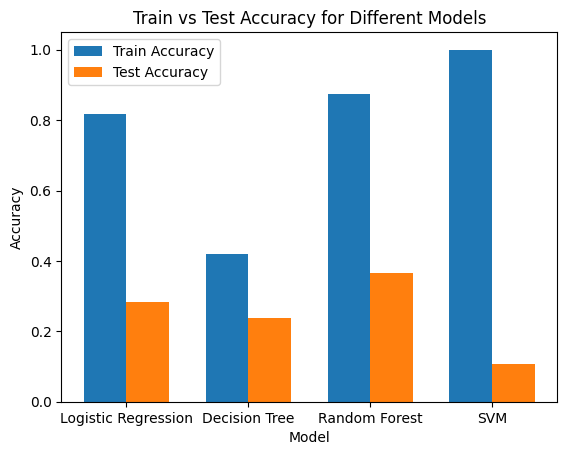

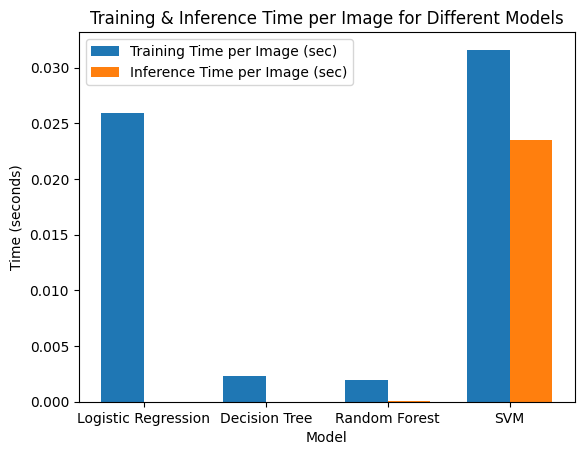

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Model names
model_names = ["Logistic Regression", "Decision Tree", "Random Forest", "SVM"]
bar_width = 0.35

# Create an array for x-axis positions
x = np.arange(len(model_names))

# Plot 1: Train vs Test Accuracy
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width / 2, train_scores, bar_width, label="Train Accuracy")
bar2 = ax.bar(x + bar_width / 2, test_scores, bar_width, label="Test Accuracy")

# Labels & Titles
ax.set_xlabel("Model")
ax.set_ylabel("Accuracy")
ax.set_title("Train vs Test Accuracy for Different Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
plt.show()

# Plot 2: Training Time vs Inference Time per Image
fig, ax = plt.subplots()
bar3 = ax.bar(x - bar_width / 2, fit_times, bar_width, label="Training Time per Image (sec)")
bar4 = ax.bar(x + bar_width / 2, inf_test_times, bar_width, label="Inference Time per Image (sec)")

# Labels & Titles
ax.set_xlabel("Model")
ax.set_ylabel("Time (seconds)")
ax.set_title("Training & Inference Time per Image for Different Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
plt.show()


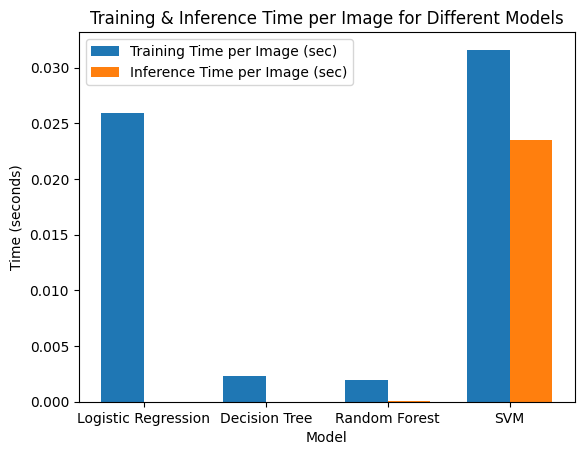

In [ ]:
# Plotting Training vs Inference Times
fig, ax = plt.subplots()

# Bar plots for training and inference times
bar1 = ax.bar(x - bar_width / 2, fit_times, bar_width, label="Training Time per Image (sec)")
bar2 = ax.bar(x + bar_width / 2, inf_test_times, bar_width, label="Inference Time per Image (sec)")

# Add labels, title, and legend
ax.set_xlabel("Model")
ax.set_ylabel("Time (seconds)")
ax.set_title("Training & Inference Time per Image for Different Models")
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

# Display the plot
plt.show()


**Q 4.4**
1. What model is the fastest to train?
2. What model is fastest to infer?
3. What model has the highest train accuracies? What model has the highest test accuracies?
4. What model would you choose to use? Why?

1. The Random Forest Model was the fastest to train.
2. The fastest to infer was Decision Tree.
3. The highest training accuracy has SVM, and the highest test accuracies has Random Forest.
4. In this context, the best model is Random Forest. With the highest test accuracy and good train accuracy, it is the best to generalise learned knowledge instead of just memorising. It is also the fastest to train.